In [1]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from collections import defaultdict
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import wandb

from models.unet import UNet
from utils.datasets import OrigaDataset, load_origa
from utils.metrics import *

In [2]:
IMAGE_DIR = '../data/ORIGA/Images_Cropped'
MASK_DIR = '../data/ORIGA/Masks_Cropped'
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
BATCH_SIZE = 4
LEARNING_RATE = 1e-4
EPOCHS = 5
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LOAD_MODEL = False
PIN_MEMORY = True if DEVICE == 'cuda' else False
USE_WANDB = False

print(f'PyTorch version: {torch.__version__}')
print(f'Using device: {DEVICE}')

PyTorch version: 2.0.1+cu118
Using device: cuda


In [3]:
config = {
    'image_size': (IMAGE_HEIGHT, IMAGE_WIDTH),
    'batch_size': BATCH_SIZE,
    'learning_rate': LEARNING_RATE,
    'epochs': EPOCHS,
}

# Initialize Weights & Biases
if USE_WANDB:
    wandb.init(project='DP-Glaucoma')
    wandb.config.update(config)

Image shape: torch.Size([1, 3, 128, 128])
Mask shape: torch.Size([1, 128, 128])
Unique values and their counts in mask: {0: 5922, 1: 5486, 2: 4976}


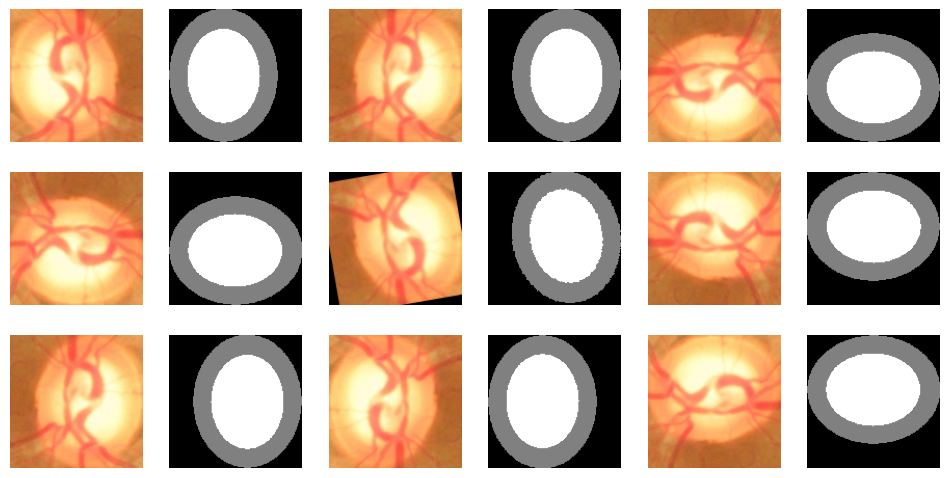

In [4]:
example_ds = OrigaDataset(IMAGE_DIR, MASK_DIR, os.listdir(IMAGE_DIR)[:1], A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=1.0),  # rotate by 0, 90, 180, or 270 degrees
    A.Rotate(limit=30, p=0.33, border_mode=cv.BORDER_CONSTANT),
    A.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0]),
    ToTensorV2(),
]))
example_loader = DataLoader(example_ds, batch_size=1, shuffle=True)

example_image, example_mask = next(iter(example_loader))
print(f'Image shape: {example_image.shape}')
print(f'Mask shape: {example_mask.shape}')

unique, counts = np.unique(example_mask, return_counts=True)
print(f'Unique values and their counts in mask: {dict(zip(unique, counts))}')

# Plot example augmented images and masks
fig, ax = plt.subplots(3, 6, figsize=(12, 6))
ax = ax.ravel()
for i in range(0, 3 * 6, 2):
    image, mask = next(iter(example_loader))
    image = image.squeeze().permute(1, 2, 0).numpy()
    mask = mask.squeeze().numpy()
    ax[i].imshow(image)
    ax[i].axis('off')
    ax[i + 1].imshow(mask, cmap='gray')
    ax[i + 1].axis('off')
plt.show()

In [5]:
train_transform = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=1.0),
    A.Rotate(limit=30, p=0.25, border_mode=cv.BORDER_CONSTANT),
    A.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0]),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0]),
    ToTensorV2()
])

train_ds, val_ds, test_ds = load_origa(
    IMAGE_DIR, MASK_DIR, train_transform, val_transform, val_transform,
    train_size=0.7, val_size=0.15, test_size=0.15,
    # train_size=0.01, val_size=0.01, test_size=0.98,
)

print(f'Train size: {len(train_ds)}')
print(f'Validation size: {len(val_ds)}')
print(f'Test size: {len(test_ds)}')

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

Train size: 454
Validation size: 98
Test size: 98


In [6]:
def save_checkpoint(state, filename='checkpoint.pth.tar'):
    print('=> Saving checkpoint')
    torch.save(state, filename)


def load_checkpoint(checkpoint, model, optimizer):
    print('=> Loading checkpoint')
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])


def get_mean_std(loader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0

    for data, _ in loader:
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data ** 2, dim=[0, 2, 3])
        num_batches += 1

    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std


In [7]:
def train_one_epoch(model, criterion, optimizer, device, loader, scheduler=None):
    model.train()
    history = defaultdict(list)
    total = len(loader)
    loop = tqdm(loader, total=total, leave=True, desc='Training')
    mean_metrics = None

    # iterate once over all the batches in the training data loader
    for batch_idx, (images, masks) in enumerate(loop):
        # move data to device
        images = images.to(device=device)
        masks = masks.to(device=device)

        # forward pass
        outputs = model(images)
        loss = criterion(outputs, masks.long())

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # calculate metrics
        preds = torch.argmax(outputs, dim=1)
        metrics = get_performance_metrics(masks.cpu(), preds.cpu())

        # update training history
        history['loss'].append(loss.item())
        for k, v in metrics.items():
            history[k].append(v)

        # display average metrics at the end of the epoch
        last_batch = batch_idx == total - 1
        if last_batch:
            mean_metrics = {k: np.mean(v) for k, v in history.items()}
            loop.set_postfix(**mean_metrics)

    # learning rate scheduler
    if scheduler is not None:
        scheduler.step(mean_metrics['loss'])

    return mean_metrics


def validate_one_epoch(model, criterion, device, loader):
    model.eval()
    history = defaultdict(list)
    total = len(loader)
    loop = tqdm(loader, total=total, leave=True, desc='Validation')
    mean_metrics = None

    # disable gradient calculation
    with torch.no_grad():
        # iterate once over all batches in the validation dataset
        for batch_idx, (images, masks) in enumerate(loop):
            images = images.to(device=device)
            masks = masks.to(device=device)

            # forward pass
            outputs = model(images)
            loss = criterion(outputs, masks.long())

            # calculate metrics
            preds = torch.argmax(outputs, dim=1)
            metrics = get_performance_metrics(masks.cpu(), preds.cpu())

            # update validation history
            history['loss'].append(loss.item())
            for k, v in metrics.items():
                history[k].append(v)

            # show summary after last batch
            last_batch = batch_idx == total - 1
            if last_batch:
                mean_metrics = {k: np.mean(v) for k, v in history.items()}
                loop.set_postfix(**mean_metrics)

    return mean_metrics


def train(model, criterion, optimizer, epochs, device, train_loader, val_loader=None, scheduler=None):
    history = defaultdict(list)
    model = model.to(device=device)

    if USE_WANDB:
        wandb.watch(model, criterion)

    for epoch in range(1, epochs + 1):
        print(f'Epoch {epoch}:')

        # training
        train_metrics = train_one_epoch(model, criterion, optimizer, device, train_loader, scheduler)
        for k, v in train_metrics.items():
            history[f'train_{k}'].append(v)

        # save checkpoint
        checkpoint = {
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
        save_checkpoint(checkpoint)

        # skip validation if loader was not provided
        if val_loader is not None:
            # validation
            val_metrics = validate_one_epoch(model, criterion, device, val_loader)
            for k, v in val_metrics.items():
                history[f'val_{k}'].append(v)

        # log metrics to wandb
        if USE_WANDB:
            wandb.log({k: v[-1] for k, v in history.items()})

    return history


In [8]:
# initialize model, loss, optimizer, scheduler, ...
unet = UNet(in_channels=3, out_channels=3, features=[64, 128, 256, 512])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(unet.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5, verbose=True)

if LOAD_MODEL:
    load_checkpoint(torch.load('checkpoint.pth.tar'), unet, optimizer)

In [9]:
hist = train(unet, criterion, optimizer, EPOCHS, DEVICE, train_loader, val_loader, scheduler)

Epoch 1:


Validation: 100%|██████████| 25/25 [00:02<00:00,  9.56it/s, accuracy=0.857, dice=0.859, iou=0.756, loss=0.407, precision=0.863, sensitivity=0.861, specificity=0.924]


Epoch 2:


Validation: 100%|██████████| 25/25 [00:02<00:00,  9.98it/s, accuracy=0.859, dice=0.862, iou=0.76, loss=0.375, precision=0.861, sensitivity=0.869, specificity=0.925]


Epoch 3:


Validation: 100%|██████████| 25/25 [00:02<00:00,  9.63it/s, accuracy=0.854, dice=0.854, iou=0.749, loss=0.371, precision=0.867, sensitivity=0.852, specificity=0.924]


Epoch 4:


Validation: 100%|██████████| 25/25 [00:02<00:00,  9.76it/s, accuracy=0.874, dice=0.875, iou=0.781, loss=0.315, precision=0.879, sensitivity=0.877, specificity=0.934]


Epoch 5:


Validation: 100%|██████████| 25/25 [00:02<00:00,  9.87it/s, accuracy=0.868, dice=0.87, iou=0.772, loss=0.322, precision=0.868, sensitivity=0.878, specificity=0.93]


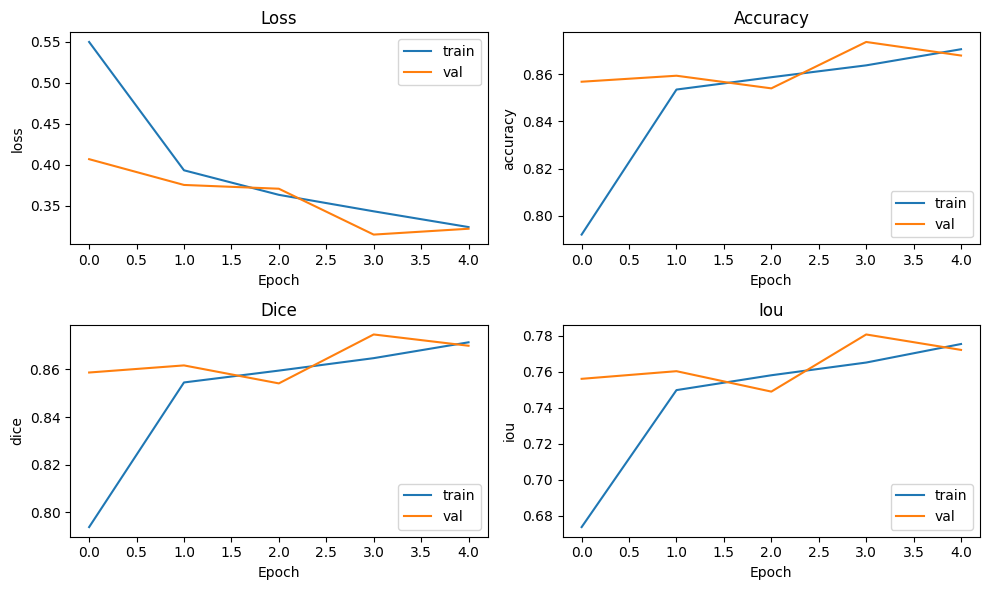

In [10]:
# Plot metrics
fig, ax = plt.subplots(2, 2, figsize=(10, 6))
ax = ax.ravel()
for i, metric in enumerate(['loss', 'accuracy', 'dice', 'iou']):
    ax[i].plot(hist[f'train_{metric}'], label=f'train')
    ax[i].plot(hist[f'val_{metric}'], label=f'val')
    ax[i].set_title(metric[0].upper() + metric[1:])
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel(metric)
    ax[i].legend()
plt.tight_layout()
plt.show()

In [15]:
def evaluate(model, criterion, device, loader):
    model.eval()
    history = defaultdict(list)
    total = len(loader)
    loop = tqdm(loader, total=total, leave=True, desc='Evaluating')
    mean_metrics = None

    with torch.no_grad():
        for batch_idx, (images, masks) in enumerate(loop):
            images = images.to(device=device)
            masks = masks.to(device=device)

            # forward pass
            outputs = model(images)
            loss = criterion(outputs, masks.long())

            # performance metrics
            preds = torch.argmax(outputs, dim=1)
            metrics = get_performance_metrics(masks.cpu(), preds.cpu())

            # update history
            history['loss'].append(loss.item())
            for k, v in metrics.items():
                history[k].append(v)

            # show mean metrics after every batch
            mean_metrics = {k: np.mean(v) for k, v in history.items()}
            loop.set_postfix(**mean_metrics)

    return mean_metrics

In [16]:
results = evaluate(unet, criterion, DEVICE, test_loader)
results

Evaluating: 100%|██████████| 25/25 [00:02<00:00,  9.41it/s, accuracy=0.858, dice=0.861, iou=0.759, loss=0.351, precision=0.86, sensitivity=0.868, specificity=0.925] 


{'loss': 0.3508826148509979,
 'accuracy': 0.8583489990234375,
 'precision': 0.8599648976290203,
 'sensitivity': 0.8684387075684141,
 'specificity': 0.9248884,
 'dice': 0.8613339202019045,
 'iou': 0.7590756265535312}

In [ ]:
# TODO:
# - Add WandB logging
# - Add model checkpoints
# - Add early stopping